# ACC & data prep for AnEn

* format: (site, lead_time, gen_date)
* meaning: (site/member, forecast lead time, initialization)

In [1]:
import os
import yaml
import copy
import math
import numpy as np
import pandas as pd
import xarray as xr
from collections import defaultdict

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
%matplotlib inline

In [3]:
dict_loc = {
    'Pituffik': (76.4, -68.575),
    'Fairbanks': (64.75, -147.4),
    'Guam': (13.475, 144.75),
    'Yuma_PG': (33.125, -114.125),
    'Fort_Bragg': (35.05, -79.115),
}
keys = list(dict_loc.keys())

In [4]:
base_dir = '/glade/derecho/scratch/ksha/EPRI_data/METRICS_STN/'

In [5]:
lat = [coords[0] for coords in dict_loc.values()]
lon = [coords[1] for coords in dict_loc.values()]

In [6]:
def detrend_linear(da, dim="time"):
    """
    Remove a best-fit linear trend along `dim` for each grid point.
    Uses an index-based time axis (0..N-1) to avoid datetime scaling issues.
    """
    t = xr.DataArray(np.arange(da.sizes[dim]), dims=dim, coords={dim: da[dim]})

    valid = np.isfinite(da)
    t_valid = t.where(valid)
    da_valid = da.where(valid)

    t_mean = t_valid.mean(dim, skipna=True)
    y_mean = da_valid.mean(dim, skipna=True)

    cov = ((t_valid - t_mean) * (da_valid - y_mean)).mean(dim, skipna=True)
    var = ((t_valid - t_mean) ** 2).mean(dim, skipna=True)

    slope = cov / var
    intercept = y_mean - slope * t_mean

    trend = slope * t + intercept
    return da - trend

### AnEn Inputs

In [7]:
list_ds = []
for stn in keys:
    fn_CESM = base_dir + f'{stn}/CESM_metrics.zarr'
    ds_CESM = xr.open_zarr(fn_CESM)
    ds_CESM = ds_CESM.rename({'init_time': 'initialization', 'lead_year': 'lead_time'})
    ds_CESM = ds_CESM.drop_vars(['lat', 'lon'])
    list_ds.append(ds_CESM)
    
ds_CESM_all = xr.concat(list_ds, dim='site')
ds_CESM_all = ds_CESM_all.assign_coords({'site': keys})
ds_CESM_all = ds_CESM_all.assign_coords(lat=('lat', lat))
ds_CESM_all = ds_CESM_all.assign_coords(lon=('lon', lon))


# ================================================ #
# anomaly
ds_CESM_all_anom = ds_CESM_all.copy()
vars_ = list(ds_CESM_all.keys())

for v in vars_:
    clim = ds_CESM_all[v].mean("initialization")
    ds_CESM_all_anom[v] = ds_CESM_all[v] - clim
ds_CESM_all_anom = ds_CESM_all_anom[vars_]
ds_CESM_all_anom = ds_CESM_all_anom.rename({v: v[:-7]+'anom' for v in ds_CESM_all_anom.data_vars})

# ================================================ #
# detrend
ds_CESM_all_detrend = ds_CESM_all.copy()
for v in vars_:
    ds_CESM_all_detrend[v] = detrend_linear(ds_CESM_all[v], dim="initialization")
ds_CESM_all_detrend = ds_CESM_all_detrend[vars_]
ds_CESM_all_detrend = ds_CESM_all_detrend.rename({v: v[:-7]+'detrend' for v in ds_CESM_all_detrend.data_vars})

ds_merge = xr.merge([ds_CESM_all, ds_CESM_all_anom, ds_CESM_all_detrend])
ds_merge = ds_merge.rename({'initialization': 'gen_date'})


# ================================================ #
# NINO 3.4
fn = '/glade/campaign/ral/hap/ksha/EPRI_data/CESM_OCN/ENSO_index.npy'
NINO34 = np.load(fn, allow_pickle=True)[()]

years = np.array(list(NINO34.keys()))

nino_index = np.empty((5, 10, 62))

for i_year, year in enumerate(years):
    nino_index[:, :, i_year] = NINO34[int(year)][2:][None, :]

ds_merge["nino_34"] = xr.DataArray(
    nino_index,
    dims=("site", "lead_time", "gen_date"),
    coords={
        "site": ds_merge .site,
        "lead_time": ds_merge .lead_time,
        "gen_date": ds_merge .gen_date,
    },)

**Rename**

In [18]:
rename_dict = {
    'PRECT_30d_default'   : 'CESM_precip_annual_max_30d',
    'PRECT_max_default'   : 'CESM_precip_max_daily',
    'PRECT_mean_default'  : 'CESM_precip_mean',
    'TREFHTMN_min_default': 'CESM_t2m_min_hour',
    'TREFHTMX_max_default': 'CESM_t2m_max_hour',
    'TREFHT_30d_default'  : 'CESM_t2m_annual_max_30d',
    'TREFHT_max_default'  : 'CESM_t2m_max_daily',
    'TREFHT_mean_default' : 'CESM_t2m_mean',
    'TREFHT_min_default'  : 'CESM_t2m_min_daily',
    'PRECT_30d_anom'      : 'CESM_anomaly_precip_annual_max_30d',
    'PRECT_max_anom'      : 'CESM_anomaly_precip_max_daily',
    'PRECT_mean_anom'     : 'CESM_anomaly_precip_mean',
    'TREFHTMN_min_anom'   : 'CESM_anomaly_t2m_min_hour',
    'TREFHTMX_max_anom'   : 'CESM_anomaly_t2m_max_hour',
    'TREFHT_30d_anom'     : 'CESM_anomaly_t2m_annual_max_30d',
    'TREFHT_max_anom'     : 'CESM_anomaly_t2m_max_daily',
    'TREFHT_mean_anom'    : 'CESM_anomaly_t2m_mean',
    'TREFHT_min_anom'     : 'CESM_anomaly_t2m_min_daily',
    'PRECT_30d_detrend'   : 'CESM_detrend_precip_annual_max_30d',
    'PRECT_max_detrend'   : 'CESM_detrend_precip_max_daily',
    'PRECT_mean_detrend'  : 'CESM_detrend_precip_mean',
    'TREFHTMN_min_detrend': 'CESM_detrend_t2m_min_hour',
    'TREFHTMX_max_detrend': 'CESM_detrend_t2m_max_hour',
    'TREFHT_30d_detrend'  : 'CESM_detrend_t2m_annual_max_30d',
    'TREFHT_max_detrend'  : 'CESM_detrend_t2m_max_daily',
    'TREFHT_mean_detrend' : 'CESM_detrend_t2m_mean',
    'TREFHT_min_detrend'  : 'CESM_detrend_t2m_min_daily',
    'nino_34'             : 'nino_34'
}

In [20]:
ds_merge = ds_merge.rename(rename_dict)

In [21]:
ds_merge.to_netcdf(
    '/glade/derecho/scratch/ksha/EPRI_AnEn/input_AnEn_CESM_20260221.nc',
    format="NETCDF4_CLASSIC",
    engine="netcdf4",
    mode='w'
)

### ERA5 target

In [29]:
list_ds = []
for stn in keys:

    fn_ERA5 = base_dir + f'{stn}/metrics.zarr'
    ds_ERA5 = xr.open_zarr(fn_ERA5)
    ds_ERA5 = ds_ERA5.drop_vars(['latitude', 'longitude'])
    years_ext = np.arange(int(ds_ERA5["year"].min()), 2036)  # 1958..2035 inclusive
    ds_ERA5 = ds_ERA5.reindex(year=years_ext)
    
    fn_CESM = base_dir + f'{stn}/CESM_metrics.zarr'
    ds_CESM = xr.open_zarr(fn_CESM)
    ds_CESM = ds_CESM.drop_vars(['lat', 'lon'])
    
    valid_year = (ds_CESM["init_time"] + ds_CESM["lead_year"]).rename("valid_year") 
    valid_year = valid_year.transpose("lead_year", "init_time") 
    ds_target = ds_ERA5.sel(year=valid_year) 
    ds_target = ds_target.drop_vars("year") #.assign_coords(valid_year=valid_year)
    list_ds.append(ds_target)
    
ds_target_all = xr.concat(list_ds, dim='site')
ds_target_all = ds_target_all.assign_coords({'site': keys})
ds_target_all = ds_target_all.assign_coords(lat=('lat', lat))
ds_target_all = ds_target_all.assign_coords(lon=('lon', lon))
ds_target_all = ds_target_all.rename({'lead_year': 'lead_time', 'init_time': 'gen_date'})

# ================================================ #
# anomaly
ds_target_all_anom = ds_target_all.copy()
vars_ = list(ds_target_all.keys())

for v in vars_:
    clim = ds_target_all[v].mean('gen_date', skipna=True)
    ds_target_all_anom[v] = ds_target_all[v] - clim
ds_target_all_anom = ds_target_all_anom[vars_]
ds_target_all_anom = ds_target_all_anom.rename({v: v[:-7]+'anom' for v in ds_target_all_anom.data_vars})

# ================================================ #
# detrend
ds_target_all_detrend = ds_target_all.copy()
for v in vars_:
    ds_target_all_detrend[v] = detrend_linear(ds_target_all[v], dim='gen_date')
ds_target_all_detrend = ds_target_all_detrend[vars_]
ds_target_all_detrend = ds_target_all_detrend.rename({v: v[:-7]+'detrend' for v in ds_target_all_detrend.data_vars})

ds_target_merge = xr.merge([ds_target_all, ds_target_all_anom, ds_target_all_detrend])

In [30]:
rename_dict = {
    'PRECT_30d_default'   : 'ERA5_precip_annual_max_30d',
    'PRECT_max_default'   : 'ERA5_precip_max_daily',
    'PRECT_mean_default'  : 'ERA5_precip_mean',
    'TREFHTMN_min_default': 'ERA5_t2m_min_hour',
    'TREFHTMX_max_default': 'ERA5_t2m_max_hour',
    'TREFHT_30d_default'  : 'ERA5_t2m_annual_max_30d',
    'TREFHT_max_default'  : 'ERA5_t2m_max_daily',
    'TREFHT_mean_default' : 'ERA5_t2m_mean',
    'TREFHT_min_default'  : 'ERA5_t2m_min_daily',
    'PRECT_30d_anom'      : 'ERA5_anomaly_precip_annual_max_30d',
    'PRECT_max_anom'      : 'ERA5_anomaly_precip_max_daily',
    'PRECT_mean_anom'     : 'ERA5_anomaly_precip_mean',
    'TREFHTMN_min_anom'   : 'ERA5_anomaly_t2m_min_hour',
    'TREFHTMX_max_anom'   : 'ERA5_anomaly_t2m_max_hour',
    'TREFHT_30d_anom'     : 'ERA5_anomaly_t2m_annual_max_30d',
    'TREFHT_max_anom'     : 'ERA5_anomaly_t2m_max_daily',
    'TREFHT_mean_anom'    : 'ERA5_anomaly_t2m_mean',
    'TREFHT_min_anom'     : 'ERA5_anomaly_t2m_min_daily',
    'PRECT_30d_detrend'   : 'ERA5_detrend_precip_annual_max_30d',
    'PRECT_max_detrend'   : 'ERA5_detrend_precip_max_daily',
    'PRECT_mean_detrend'  : 'ERA5_detrend_precip_mean',
    'TREFHTMN_min_detrend': 'ERA5_detrend_t2m_min_hour',
    'TREFHTMX_max_detrend': 'ERA5_detrend_t2m_max_hour',
    'TREFHT_30d_detrend'  : 'ERA5_detrend_t2m_annual_max_30d',
    'TREFHT_max_detrend'  : 'ERA5_detrend_t2m_max_daily',
    'TREFHT_mean_detrend' : 'ERA5_detrend_t2m_mean',
    'TREFHT_min_detrend'  : 'ERA5_detrend_t2m_min_daily',
}

In [31]:
ds_target_merge = ds_target_merge.rename(rename_dict)

In [35]:
# ds_target_merge['ERA5_detrend_t2m_mean'].values[0, -1, :]

In [36]:
# NaN to -9999
fill = -9999.0

encoding = {}
for v in ds_target_merge.data_vars:
    encoding[v] = {"_FillValue": fill}

ds_target_merge.to_netcdf(
    '/glade/derecho/scratch/ksha/EPRI_AnEn/input_AnEn_ERA5_20260221.nc',
    format="NETCDF4_CLASSIC",
    engine="netcdf4",
    encoding=encoding,
    mode='w'
)

### Check timeseries 

In [37]:
fn_input = '/glade/derecho/scratch/ksha/EPRI_AnEn/input_AnEn_CESM_20260221.nc'
fn_target = '/glade/derecho/scratch/ksha/EPRI_AnEn/input_AnEn_ERA5_20260221.nc'

ds_input = xr.open_dataset(fn_input)
ds_target = xr.open_dataset(fn_target)

In [40]:
T2_mean_CESM = ds_input['CESM_t2m_mean'].isel(site=2).values
T2_mean_ERA5 = ds_target['ERA5_t2m_mean'].isel(site=2).values

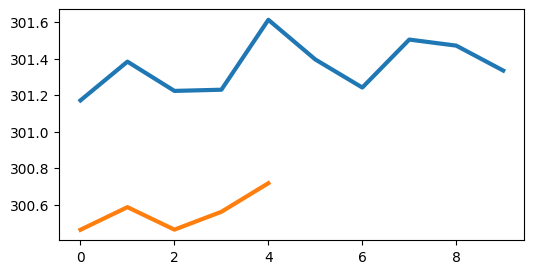

In [41]:
plt.figure(figsize=(6, 3))
plt.plot(T2_mean_CESM[:, -1], lw=3)
plt.plot(T2_mean_ERA5[:, -1], lw=3)

### ACC

In [49]:
fn_input = '/glade/derecho/scratch/ksha/EPRI_AnEn/input_AnEn_CESM_20260221.nc'
fn_target = '/glade/derecho/scratch/ksha/EPRI_AnEn/input_AnEn_ERA5_20260221.nc'

ds_input = xr.open_dataset(fn_input)
ds_target = xr.open_dataset(fn_target)

In [54]:
ds_input = ds_input.rename({v: 'ERA5'+v[4:] for v in ds_input.data_vars})

In [56]:
list_ACC_lead = []

varnames = list(ds_target.keys())

for i_lead in range(10):
    list_ACC_var = []
    for varname in varnames:
        input_ = ds_input[varname].isel(lead_time=i_lead)
        target_ = ds_target[varname].isel(lead_time=i_lead)
        
        mask = target_.notnull()
        input_clean  = input_.where(mask, drop=True)
        target_clean = target_.where(mask, drop=True)
        
        if len(target_clean['gen_date']) > 10:
            list_ACC_var.append(
                xr.corr(
                    input_clean, 
                    target_clean, 
                    dim="gen_date"
                )
            )
    ds_ACC_lead = xr.merge(list_ACC_var)
    list_ACC_lead.append(ds_ACC_lead)

ds_ACC = xr.concat(list_ACC_lead, dim='lead_time')

In [57]:
ds_ACC.to_zarr(base_dir+'ACC_all.zarr', mode='w')

### Plot

In [58]:
ds_ACC = xr.open_zarr(base_dir+'ACC_all.zarr')

In [46]:
lead_dim="lead_time"
site_dim="site"
variants=("anom", "default", "detrend")
ncols=3
sharey=True

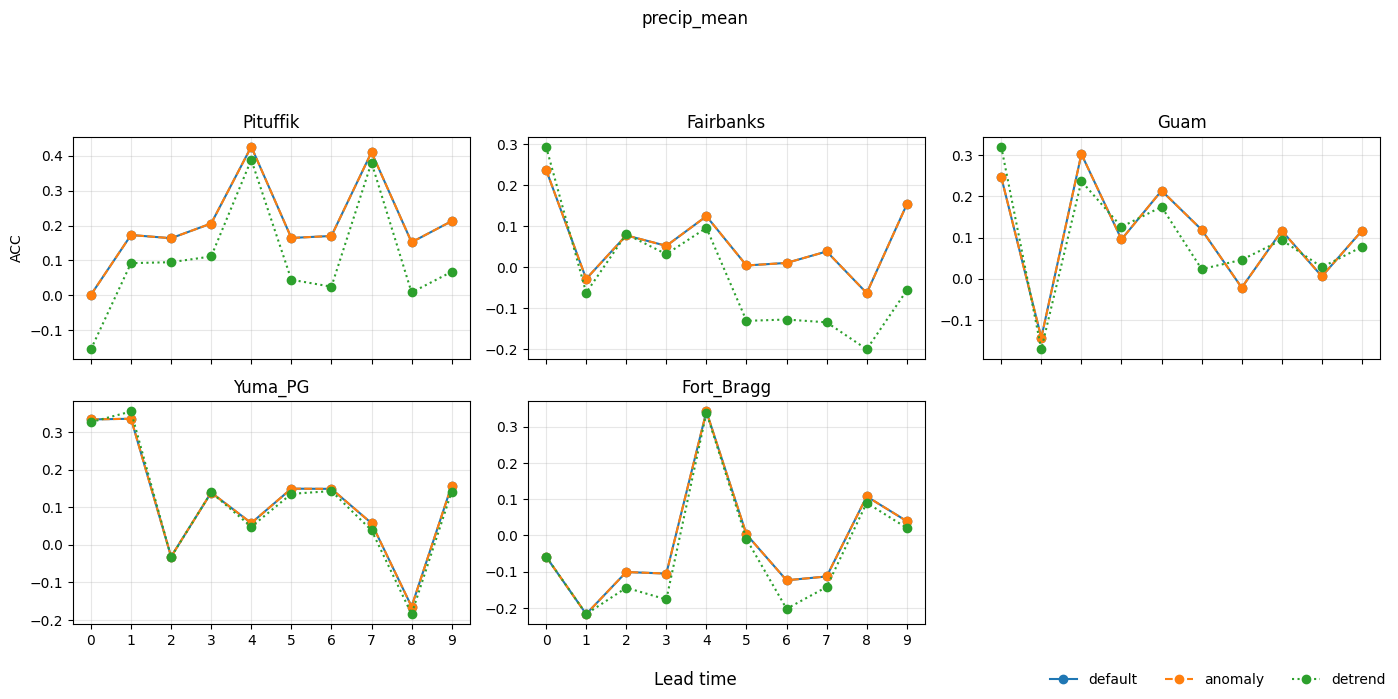

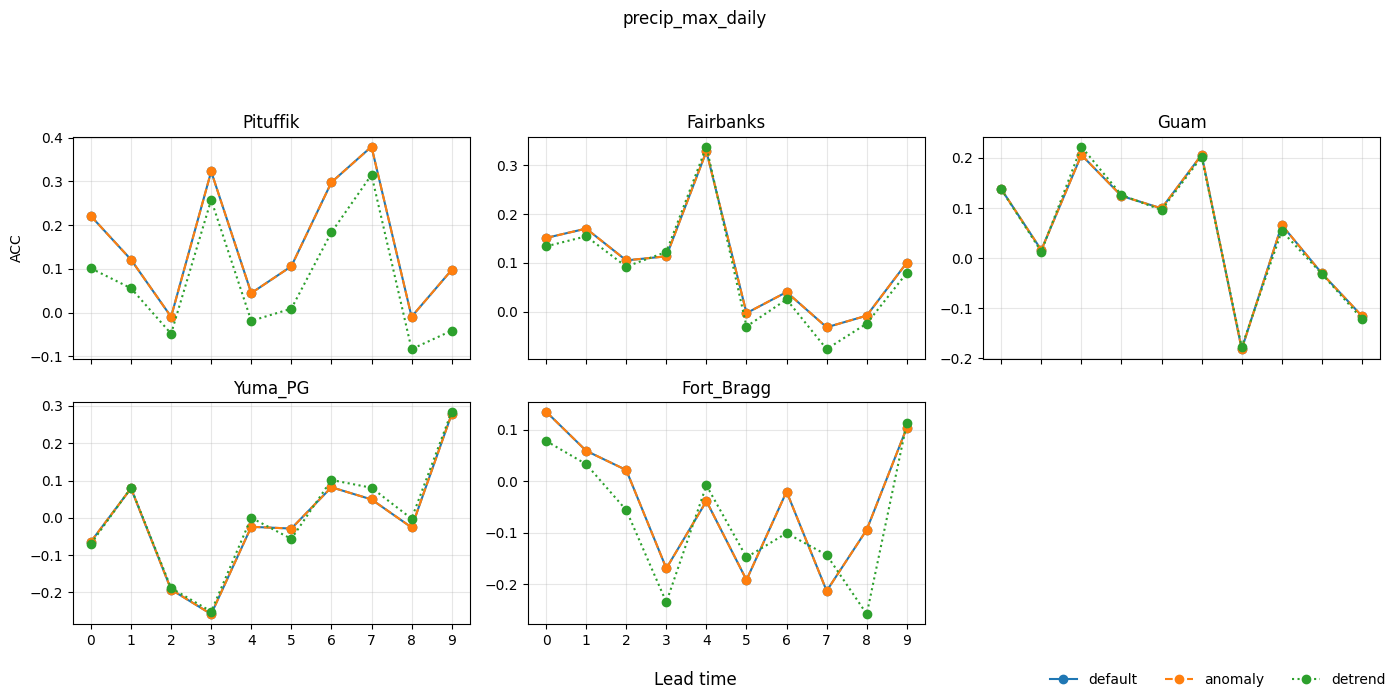

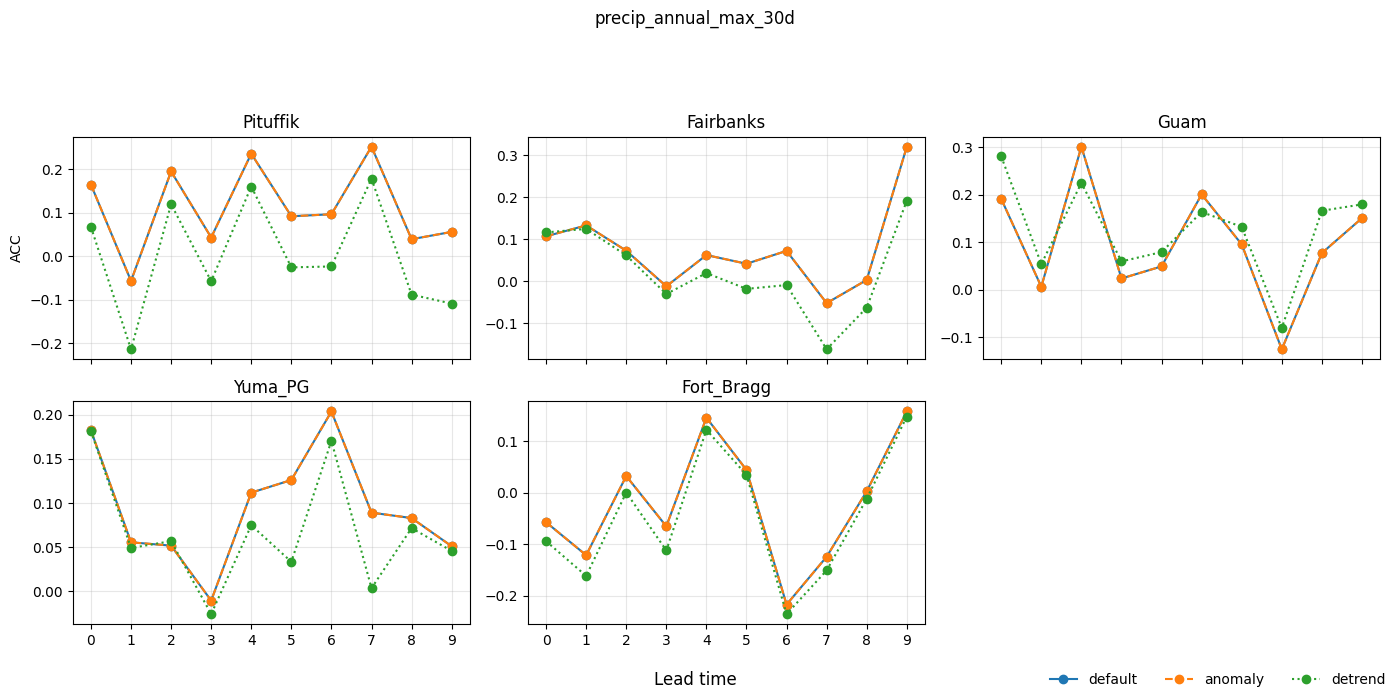

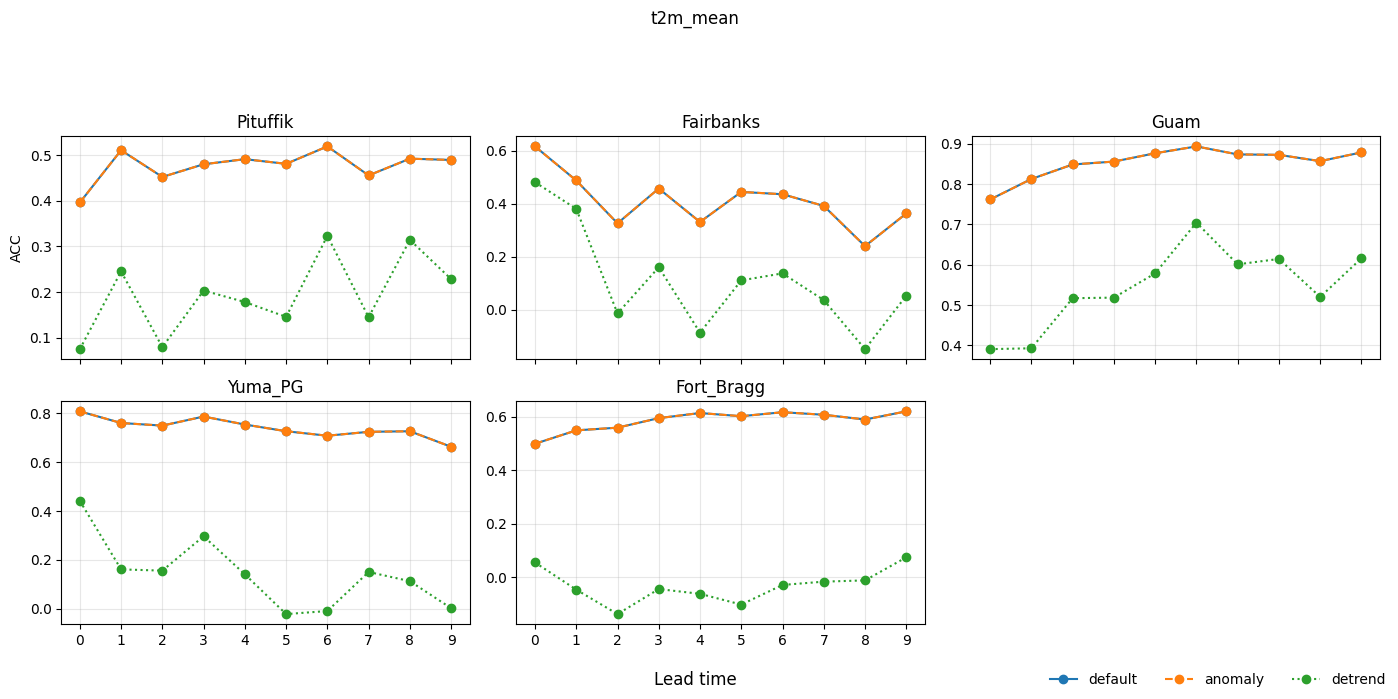

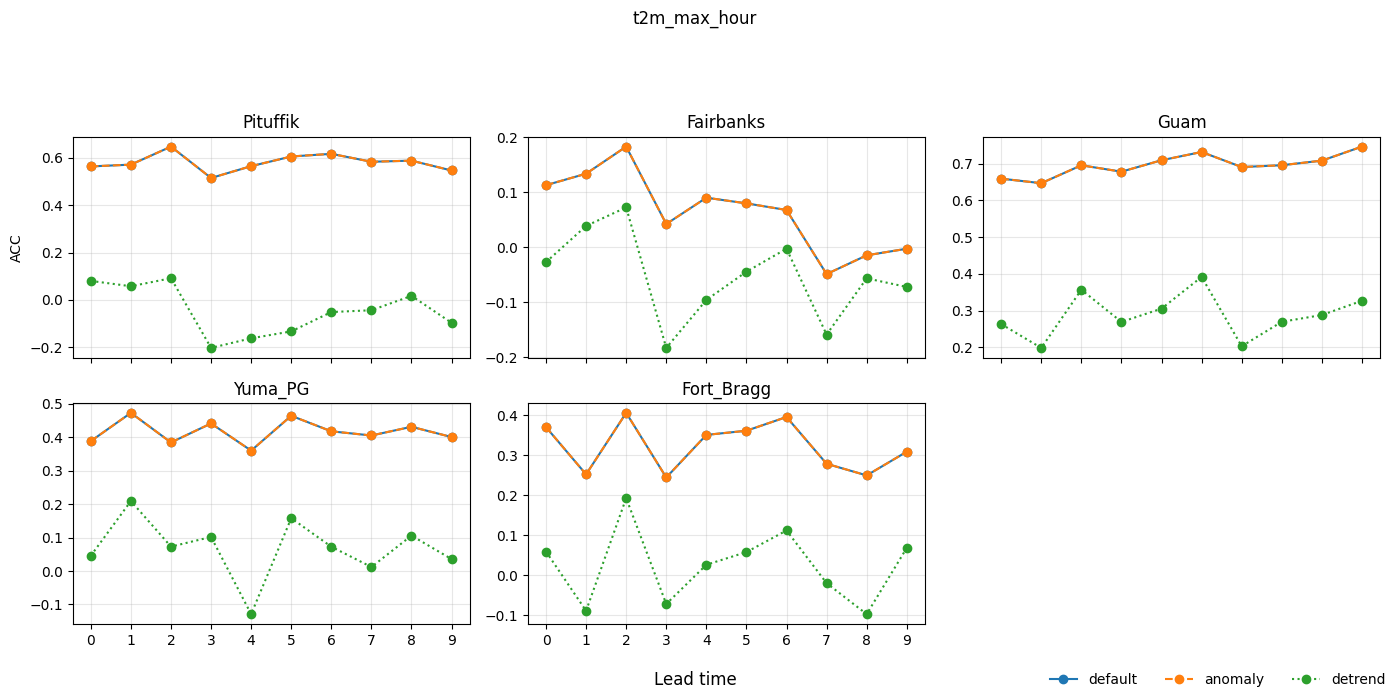

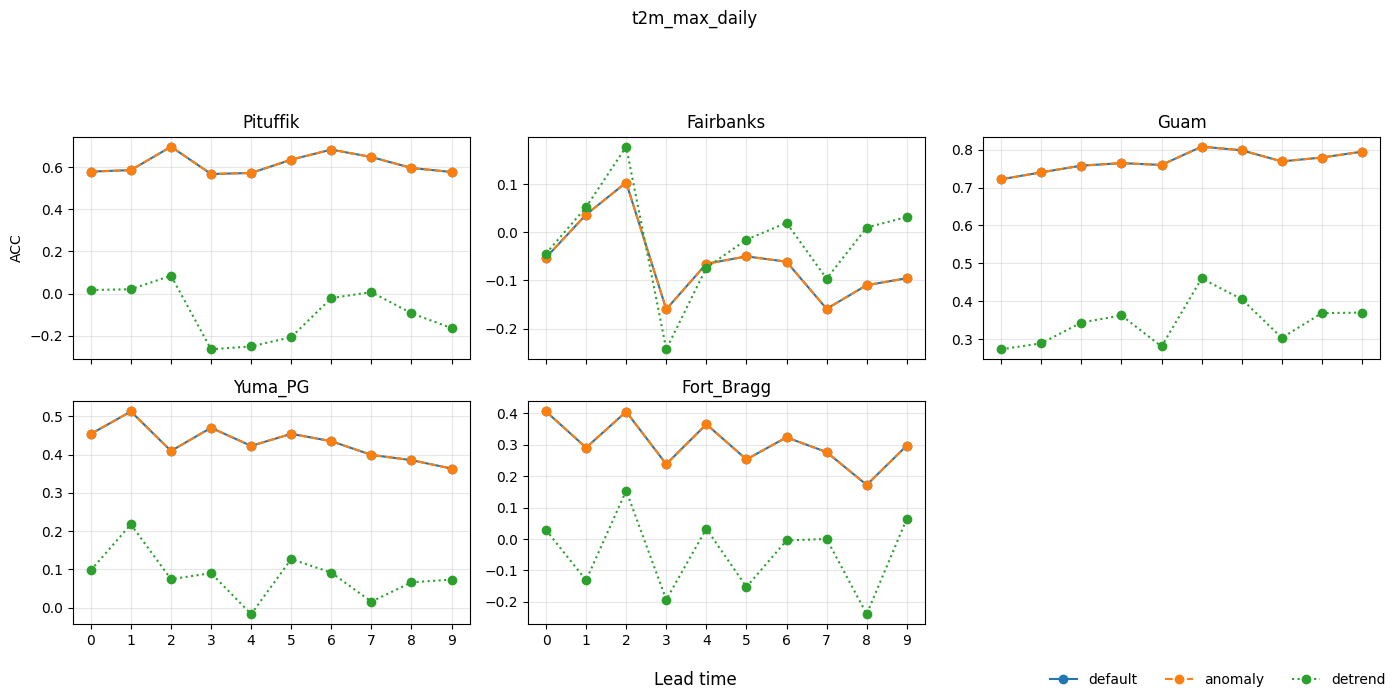

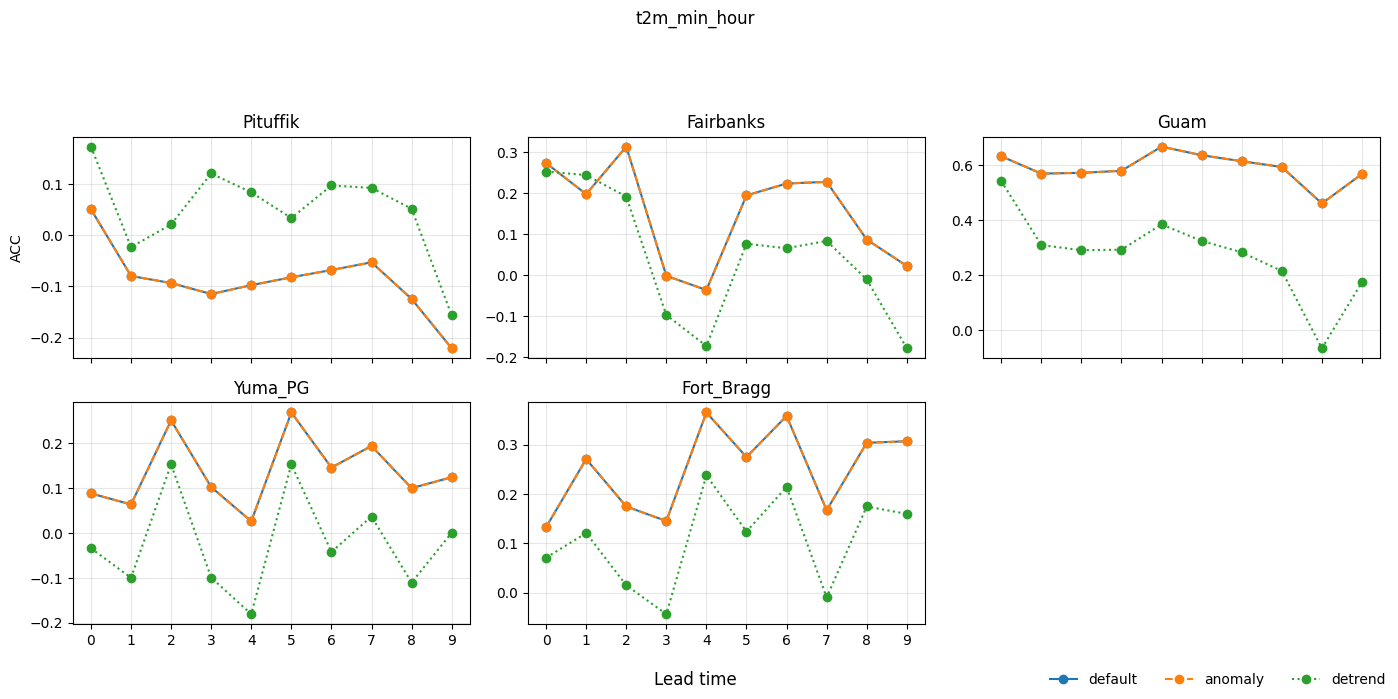

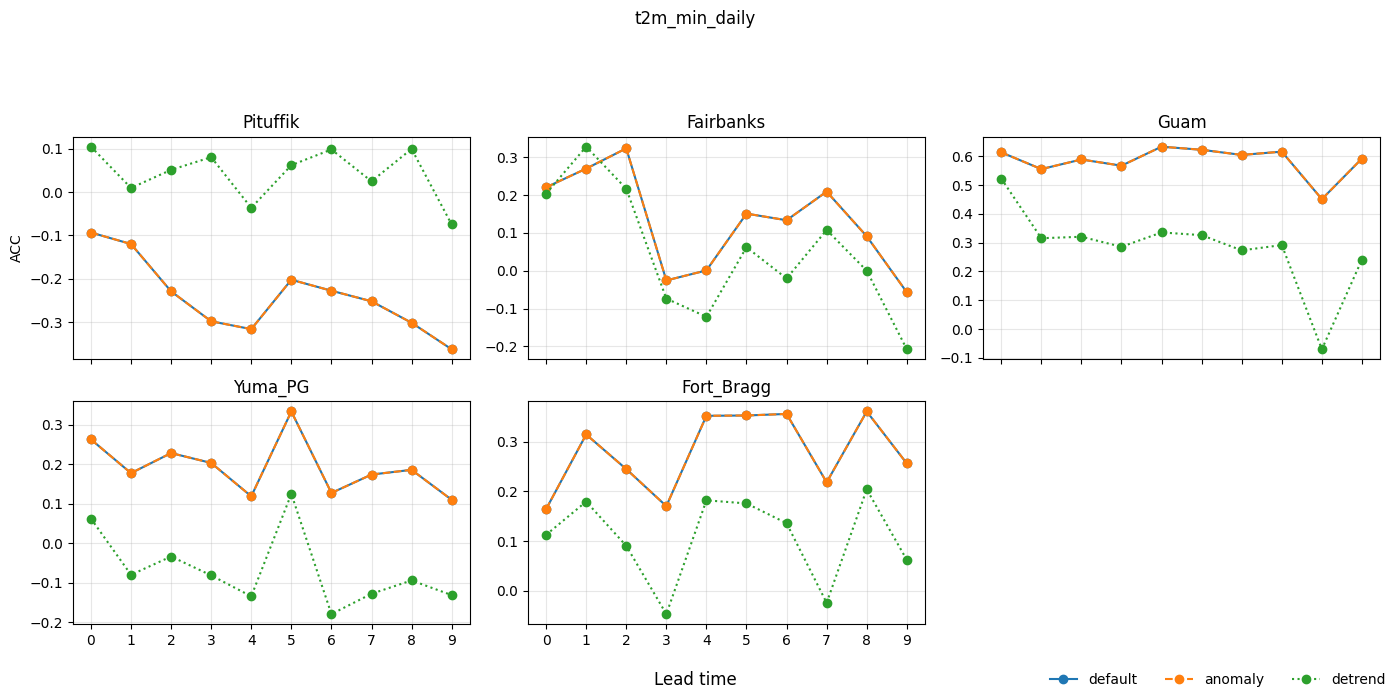

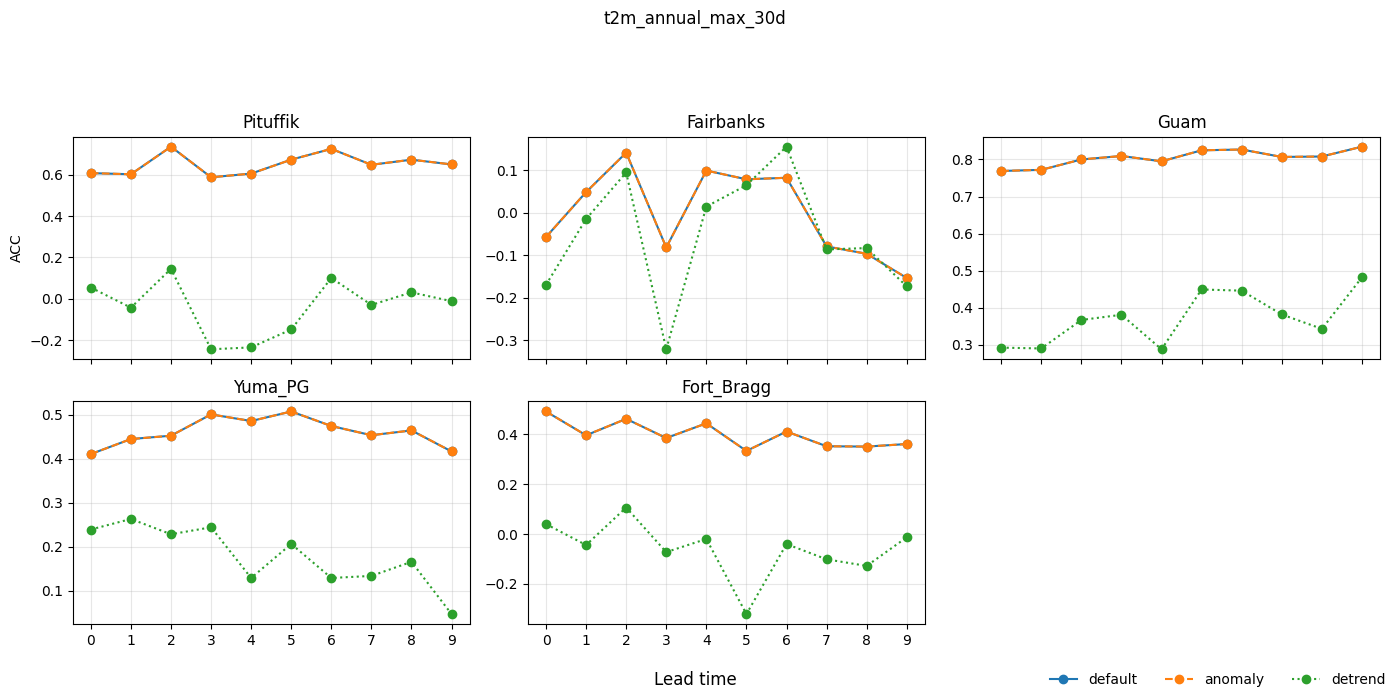

In [63]:
ds = ds_ACC

site_dim = "site"
lead_dim = "lead_time"

# label -> variable prefix
label_to_prefix = {
    "default":    "ERA5_",
    "anomaly": "ERA5_anomaly_",
    "detrend": "ERA5_detrend_",
}

# Optional: line styles for readability (keeps matplotlib default colors)
label_to_style = {
    "default":    "-",
    "anomaly": "--",
    "detrend": ":",
}

# ---- find metric suffixes robustly (avoid "anomaly_t2m_mean" artifacts) ----
prefixes_sorted = sorted(label_to_prefix.values(), key=len, reverse=True)

metrics = set()
for var in ds.data_vars:
    for p in prefixes_sorted:
        if var.startswith(p):
            metrics.add(var[len(p):])
            break

# Optional: impose a nicer order instead of alphabetical
preferred_order = [
    "precip_mean", "precip_max_daily", "precip_annual_max_30d",
    "t2m_mean", "t2m_max_hour", "t2m_max_daily",
    "t2m_min_hour", "t2m_min_daily", "t2m_annual_max_30d",
]
# Use preferred order when possible, then append anything else found
metrics = [m for m in preferred_order if m in metrics] + sorted(set(metrics) - set(preferred_order))

sites = ds[site_dim].values
lead = ds[lead_dim].values

for metric in metrics:
    triplet = {lbl: pref + metric for lbl, pref in label_to_prefix.items()}
    missing = [v for v in triplet.values() if v not in ds.data_vars]
    if missing:
        print(f"Skipping metric '{metric}' (missing vars: {missing})")
        continue

    # 5 sites -> use a 2x3 grid, hide the 6th axis
    fig, axes = plt.subplots(2, 3, figsize=(14, 7), sharex=True)
    axes = axes.ravel()

    for i, site in enumerate(sites):
        ax = axes[i]
        for lbl, varname in triplet.items():
            y = ds[varname].sel({site_dim: site}).transpose(lead_dim).to_numpy()
            ax.plot(
                lead, y,
                linestyle=label_to_style.get(lbl, "-"),
                marker="o",
                label=lbl
            )

        ax.set_title(str(site))
        ax.set_xticks(lead)
        ax.grid(True, alpha=0.3)

        # If this really is ACC, uncomment to standardize all panels:
        # ax.set_ylim(-1, 1)

    # hide unused axes
    for j in range(len(sites), len(axes)):
        axes[j].set_visible(False)

    axes[0].set_ylabel("ACC")
    fig.supxlabel("Lead time")
    fig.suptitle(metric)

    # single shared legend (use handles from first visible axis)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower right", ncol=3, frameon=False)
    
    fig.tight_layout(rect=[0, 0, 1, 0.90])